In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime
import numpy as np


In [3]:
#Create list of Worlds Day 2 players+decks from Limitless

# The URL you want to scrape
url = "https://limitlesstcg.com/tournaments/375"

# Fetch the HTML content
response = requests.get(url)
if response.status_code != 200:
    print("Failed to get the webpage")
    exit()

# Initialize BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Lists to hold the player names and decks
player_names = []
decks = []

# Loop through each player row in the HTML
for row in soup.select('tr'):
    player = row.select_one('a[href^="/players"]')
    deck = row.select_one('span[data-tooltip]')
    
    if player and deck:
        player_names.append(player.text)
        
        deck_tooltip = deck['data-tooltip']
        decks.append(deck_tooltip)

# Create a DataFrame
player_decks = pd.DataFrame({
    'Player Name': player_names,
    'Deck': decks
})

# Print the DataFrame or save it to a CSV file
player_decks['Player Name'] = player_decks['Player Name'].str.strip().str.lower()

rename_dict = {'tom mizutani':'tomu mizutani',
            'hiromi isono': '広明 磯野',
            'aaron friedman' : 'aaron freetos friedman',
       'tadashi miyamoto' : 'da ashi',
            'juan andree mejía' : 'juan andree',
            'agustin campo' : 'agustín campo',
       'tomoyuki abino' : '阿比野 友之', 
            'isaac chen im sheng' : 'im sheng chen', 
            'shunsuke sowa' : '俊介 曽羽',
       'akari yamanoto' : 'akari yamamoto'}
player_decks['Player Name'].replace(rename_dict, inplace=True)
worlds_day2_decks = player_decks
#df.to_csv('player_decks.csv', index=False)

In [4]:
#Create list of Worlds Day 1 Players and Decks
worlds_day1_decks = pd.read_excel("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/Worlds Day 1_decks.xlsx")
worlds_day1_decks = worlds_day1_decks[['name', 'deck']]
worlds_day1_decks=worlds_day1_decks.rename(columns={'name' : 'Player Name', 'deck' : 'Deck'})
worlds_day1_decks['Player Name']=worlds_day1_decks['Player Name'].str.strip().str.lower()




In [5]:
def clean_standings(csv):
    matches = pd.read_csv(csv, header=None)
    matches[['Player1', 'Country1', 'Player2', 'Country2', 'Result']] = matches[0].str.extract(r'([\w\s-]+)\s\[(\w+)\]\t([\w\s-]+)\s\[(\w+)\]\t([WLT])')
    matches.drop(0, axis=1, inplace=True)
    players = matches[['Player1', 'Player2', 'Result']]
    players['Player1'] = players['Player1'].str.strip().str.lower()
    players['Player2'] = players['Player2'].str.strip().str.lower()
    players=players.dropna()
    return players

In [6]:
players_day2 = clean_standings("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/worlds_day2.csv")
players_day1 = clean_standings("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/worlds_day1.csv")
rename_dict_day1 = {'akari yamamoto' : 'akari yamanoto', 
                    'onofrio' : "christian d'onofrio", 
                    'h eriksen' : 'jesper s.h eriksen', 
                    'compley' : 'esteban o’compley', 
                    'kouhei nagahama' : 'kohei nagahama' ,
                    'table 201 - vinicius augusto gomes' : 'vinicius augusto gomes' ,
                    'nguyen' : 'thai d. nguyen',
                    'brien' : "vaughn o'brien",
                    'meara' : "darin o'meara"}

players_day1['Player1'].replace(rename_dict_day1, inplace=True)
players_day1['Player2'].replace(rename_dict_day1, inplace=True)

<ipython-input-5-6f7fbf4096f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Player1'] = players['Player1'].str.strip().str.lower()
<ipython-input-5-6f7fbf4096f7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Player2'] = players['Player2'].str.strip().str.lower()
<ipython-input-5-6f7fbf4096f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [7]:
#Test for names that don't match between decks and standings/matches
def test_no_matching_names_left(players1, players2):
    testing = players1.merge(players2, left_on='Player1', right_on='Player Name', how='left')
    testing_na = testing[testing.isna().any(axis=1)]
    return testing_na['Player1'].unique()

def test_no_matching_names_right(players1, players2):
    testing = players1.merge(players2, left_on='Player1', right_on='Player Name', how='right')
    testing_na = testing[testing.isna().any(axis=1)]
    return testing_na['Player Name'].unique()

In [8]:
print(test_no_matching_names_left(players_day1, worlds_day1_decks))
print(test_no_matching_names_right(players_day1, worlds_day1_decks))

['andreas møller' 'jonatan torres']
[]


In [9]:
#make matchup tables

def get_deck_matchups(players1, players2):
    deck_matchups = players1.merge(players2, left_on='Player1', right_on='Player Name', how='left')
    deck_matchups.rename(columns={'Deck': 'Deck1'}, inplace=True)
    deck_matchups.drop('Player Name', axis=1, inplace=True)

    deck_matchups = deck_matchups.merge(players2, left_on='Player2', right_on='Player Name', how='left')
    deck_matchups.rename(columns={'Deck': 'Deck2'}, inplace=True)
    deck_matchups.drop('Player Name', axis=1, inplace=True)

    deck_matchups.drop(['Player1', 'Player2'], axis=1, inplace=True)
    deck_matchups = deck_matchups.dropna()


    # Initialize an empty dictionary to hold matchups
    matchup_dict = {}

    # Iterate through each row to populate the matchup dictionary
    for _, row in deck_matchups.iterrows():
        deck1, deck2, result = row['Deck1'], row['Deck2'], row['Result']
        if deck1 not in matchup_dict:
            matchup_dict[deck1] = {}
        if deck2 not in matchup_dict[deck1]:
            matchup_dict[deck1][deck2] = {'W': 0, 'L': 0, 'T': 0}

        # Update based on result
        if result == 'W':
            matchup_dict[deck1][deck2]['W'] += 1
        elif result == 'L':
            matchup_dict[deck1][deck2]['L'] += 1
        elif result == 'T':
            matchup_dict[deck1][deck2]['T'] += 1

    # Convert to DataFrame
    final_data = {}
    for deck1, opponents in matchup_dict.items():
        for deck2, records in opponents.items():
            final_data[(deck1, deck2)] = f"{records['W']}-{records['L']}-{records['T']}"

    # Create an empty DataFrame with unique decks as index and columns
    unique_decks = list(set(deck_matchups['Deck1'].unique().tolist() + deck_matchups['Deck2'].unique().tolist()))
    matchup_df = pd.DataFrame(index=unique_decks, columns=unique_decks)

    # Populate the DataFrame
    for (deck1, deck2), record in final_data.items():
        matchup_df.at[deck1, deck2] = record

        
    unique_decks = sorted(list(set(deck_matchups['Deck1'].unique().tolist() + deck_matchups['Deck2'].unique().tolist())))
    matchup_df = pd.DataFrame(index=unique_decks, columns=unique_decks)

    # Populate the DataFrame
    for (deck1, deck2), record in final_data.items():
        matchup_df.at[deck1, deck2] = record

    # Sort index and columns alphabetically
    matchup_df.sort_index(axis=0, inplace=True)
    matchup_df.sort_index(axis=1, inplace=True)
    
    return matchup_df



def calc_percentage(wlt_str):
    if pd.isna(wlt_str):
        return None
    w, l, t = map(int, wlt_str.split('-'))
    if w + l == 0:
        return None
    return round((w / (w + l)) * 100,1)

In [10]:
worlds_day2_matchups = get_deck_matchups(players_day2, worlds_day2_decks)
worlds_day1_matchups = get_deck_matchups(players_day1, worlds_day1_decks)

In [11]:
worlds_day2_percents = worlds_day2_matchups.applymap(calc_percentage)
worlds_day1_percents = worlds_day1_matchups.applymap(calc_percentage)

In [84]:
worlds_day1_decks['Deck'].value_counts()

Gardevoir                   95
Single Strike Lugia         90
Giratina LZ Box             90
Lost Zone Box               84
Arceus Giratina             67
Fusion Mew                  53
Chien-Pao Baxcalibur        45
Inteleon Urshifu            24
Arceus Duraludon Umbreon    22
Palkia Chien-Pao            17
Miraidon Flaaffy            15
Arceus Umbreon              14
Arceus                      13
Lugia Archeops              12
Mew Genesect                 8
Miraidon Regieleki           6
Arceus Goodra                5
Lost Box Charizard           4
Arceus Flying Pikachu        3
Goodra LZ Box                3
Hisuian Zoroark              2
Shadow Rider Calyrex         2
Gardevoir Mewtwo             2
Ting-Lu                      2
Zoroark Box                  1
Miraidon                     1
Palkia                       1
Inteleon                     1
Omastar Archeops             1
Noivern                      1
Arceus Aerodactyl            1
Reversal Gardevoir           1
Arceus D

In [283]:
#if we want to consolidate some names
worlds_day2_decks_consolidated = worlds_day2_decks.copy()
worlds_day1_decks_consolidated = worlds_day1_decks.copy()

replace_decks_dict_day2 = {'Miraidon Flaaffy' : 'Miraidon', 
                        'Miraidon Regieleki' : 'Miraidon',
                        'Arceus Umbreon' : 'Arceus no Tina', 
                        'Arceus Duraludon Umbreon' : 'Arceus no Tina',
                        'Arceus' : 'Arceus no Tina', 
                        'Arceus Goodra' : 'Arceus no Tina',
                        'Arceus Duraludon' : 'Arceus no Tina', 
                        'Arceus Giratina Umbreon' : 'Arceus Giratina',
                        'Fusion Mew' : 'Mew', 
                      'Mew Genesect' : 'Mew'}

replace_decks_dict_day1 = {'Miraidon Flaaffy' : 'Miraidon', 
                        'Miraidon Regieleki' : 'Miraidon',
                        'Arceus Umbreon' : 'Arceus no Tina', 
                        'Arceus Duraludon Umbreon' : 'Arceus no Tina',
                        'Arceus' : 'Arceus no Tina', 
                        'Arceus Goodra' : 'Arceus no Tina',
                        'Arceus Duraludon' : 'Arceus no Tina', 
                        'Arceus Giratina Umbreon' : 'Arceus Giratina',
                           'Arceus Flying Pikachu' : 'Arceus no Tina',
                           'Arceus Meowscarada' : 'Arceus no Tina',
                           'Arceus Aerodactyl' : 'Arceus no Tina',
                           'Reversal Gardevoir' : 'Gardevoir',
                        'Fusion Mew' : 'Mew', 
                      'Mew Genesect' : 'Mew',
                          'Single Strike Lugia' : 'Lugia Archeops',
                           'Gardevoir Mewtwo' : 'Gardevoir',
                           'Lost Box Charizard' : 'Lost Zone Box',
                           'Palkia' : 'Palkia Chien-Pao'
                          }


worlds_day2_decks_consolidated['Deck'] = worlds_day2_decks_consolidated['Deck'].replace(replace_decks_dict_day2)
worlds_day1_decks_consolidated['Deck'] = worlds_day1_decks_consolidated['Deck'].replace(replace_decks_dict_day1)
# Get the value counts
value_counts_day2 = worlds_day2_decks_consolidated['Deck'].value_counts()
value_counts_day1 = worlds_day1_decks_consolidated['Deck'].value_counts()

# Select the values where the count > 2
to_keep_2 = value_counts_day2[value_counts_day2 > 2].index
to_keep_1 = value_counts_day1[value_counts_day1 > 5].index


# Filter the DataFrame to keep these values only
worlds_day2_decks_consolidated = worlds_day2_decks_consolidated[worlds_day2_decks_consolidated['Deck'].isin(to_keep_2)]
worlds_day1_decks_consolidated = worlds_day1_decks_consolidated[worlds_day1_decks_consolidated['Deck'].isin(to_keep_1)]



In [288]:
worlds_day2_matchups_consolidated = get_deck_matchups(players_day2, worlds_day2_decks_consolidated)
worlds_day2_consolidated_percents = worlds_day2_matchups_consolidated.applymap(calc_percentage)

worlds_day1_matchups_consolidated = get_deck_matchups(players_day1, worlds_day1_decks_consolidated)
worlds_day1_consolidated_percents = worlds_day1_matchups_consolidated.applymap(calc_percentage)
worlds_day1_consolidated_percents.fillna(50, inplace=True)

Consolidate Decks

In [12]:
worlds_day2_matchups

,Arceus,Arceus Duraludon,Arceus Duraludon Umbreon,Arceus Giratina,Arceus Giratina Umbreon,Arceus Goodra,Arceus Umbreon,Chien-Pao Baxcalibur,Counter Box,Fusion Mew,...,Inteleon Urshifu,Lost Box Charizard,Lost Zone Box,Lugia Archeops,Mew Genesect,Miraidon Flaaffy,Miraidon Regieleki,Palkia Chien-Pao,Palkia Gardevoir,Zoroark Box
Arceus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-0-0,...,1-1-0,NaN,1-0-1,0-1-0,NaN,NaN,NaN,NaN,NaN,NaN
Arceus Duraludon,NaN,NaN,NaN,0-1-0,NaN,NaN,NaN,NaN,0-1-0,NaN,...,NaN,NaN,0-1-1,2-0-0,NaN,0-1-0,NaN,NaN,NaN,NaN
Arceus Duraludon Umbreon,NaN,NaN,NaN,0-1-0,NaN,0-1-0,0-1-0,NaN,NaN,1-1-0,...,NaN,NaN,1-1-0,1-0-0,0-1-0,NaN,NaN,NaN,NaN,NaN
Arceus Giratina,NaN,1-0-0,1-0-0,2-2-0,0-1-0,NaN,NaN,1-3-0,NaN,2-12-0,...,1-2-0,NaN,1-7-2,1-9-0,1-0-0,1-0-0,0-2-0,0-1-0,1-1-0,NaN
Arceus Giratina Umbreon,NaN,NaN,NaN,1-0-0,NaN,NaN,NaN,0-1-0,NaN,2-2-0,...,0-0-1,NaN,0-0-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arceus Goodra,NaN,NaN,1-0-0,NaN,NaN,NaN,NaN,NaN,0-1-0,NaN,...,NaN,NaN,0-3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arceus Umbreon,NaN,NaN,1-0-0,NaN,NaN,NaN,NaN,NaN,NaN,5-3-0,...,NaN,NaN,3-3-0,2-1-1,NaN,NaN,0-1-0,NaN,NaN,NaN
Chien-Pao Baxcalibur,NaN,NaN,NaN,3-1-0,1-0-0,NaN,NaN,3-3-0,1-0-0,5-7-2,...,2-1-0,0-0-1,5-5-3,3-7-1,NaN,1-1-0,NaN,0-1-0,1-0-0,0-0-1
Counter Box,NaN,1-0-0,NaN,NaN,NaN,1-0-0,NaN,0-1-0,NaN,NaN,...,0-1-0,NaN,0-0-1,1-0-1,NaN,NaN,NaN,NaN,NaN,NaN
Fusion Mew,0-1-0,NaN,1-1-0,12-2-0,2-2-0,NaN,3-5-0,7-5-2,NaN,16-16-2,...,2-0-0,NaN,7-8-6,6-11-0,1-0-0,3-1-1,1-0-0,1-1-0,0-1-0,1-0-0


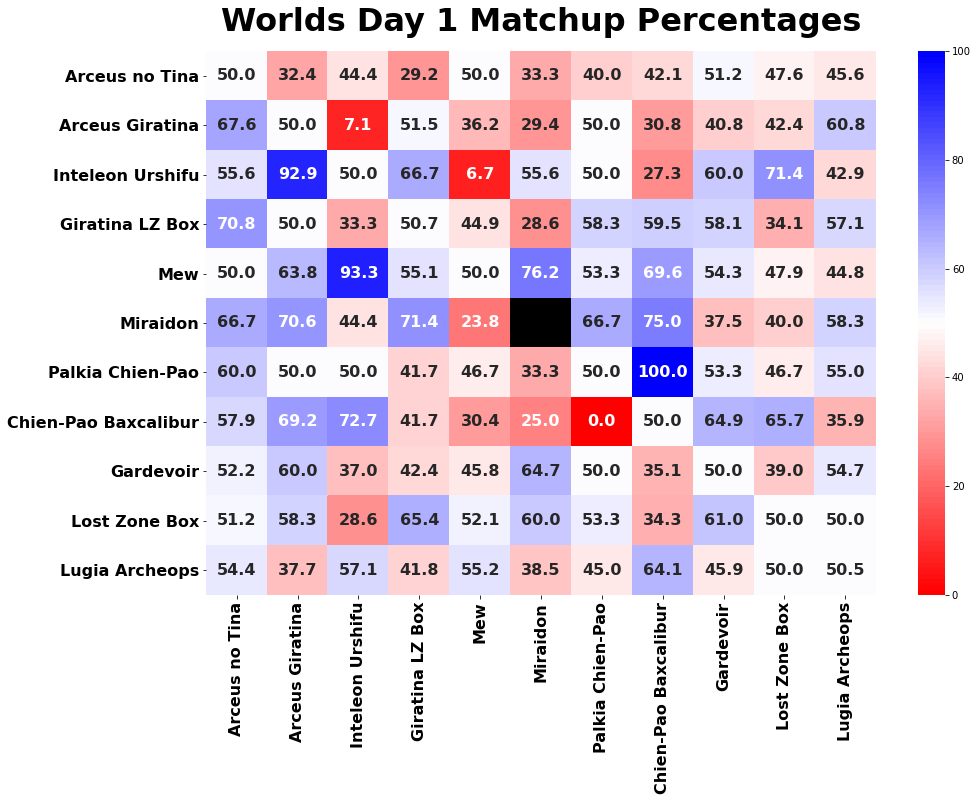

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100  # Number of bins
cmap_name = 'custom1'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='black')

plt.figure(figsize=(15, 10))
ax = sns.heatmap(worlds_day1_consolidated_percents, annot=True, cmap=custom_cmap, fmt=".1f", 
            annot_kws={"weight": "bold", "size": 16})


plt.xticks(fontweight='bold', fontsize= 16)
plt.yticks(fontweight='bold', fontsize= 16)

plt.title('Worlds Day 1 Matchup Percentages', fontweight='bold', fontsize= 32, pad=20)


plt.show()


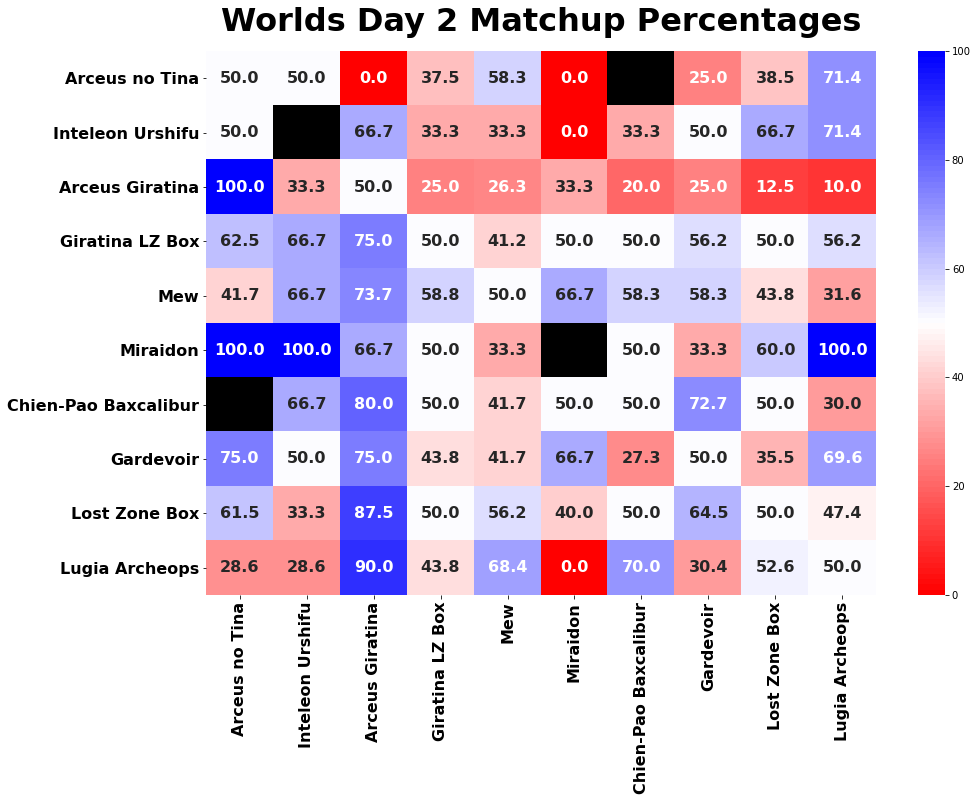

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100  # Number of bins
cmap_name = 'custom1'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='black')

plt.figure(figsize=(15, 10))
ax = sns.heatmap(worlds_day2_consolidated_percents, annot=True, cmap=custom_cmap, fmt=".1f", 
            annot_kws={"weight": "bold", "size": 16})


plt.xticks(fontweight='bold', fontsize= 16)
plt.yticks(fontweight='bold', fontsize= 16)

plt.title('Worlds Day 2 Matchup Percentages', fontweight='bold', fontsize= 32, pad=20)


plt.show()


In [ ]:
worlds_day2_matchups.to_excel("worlds_day2_matchups_records_full.xlsx")
worlds_day2_percents.to_excel("worlds_day2_matchups_percent_full.xlsx")
worlds_day2_matchups_consolidated.to_excel("worlds_day2_matchups_records_consolidated.xlsx")
worlds_day2_consolidated_percents.to_excel("worlds_day2_matchups_percent_consolidated.xlsx")

worlds_day1_matchups.to_excel("worlds_day1_matchups_records_full.xlsx")
worlds_day1_percents.to_excel("worlds_day1_matchups_percent_full.xlsx") 
worlds_day1_matchups_consolidated.to_excel("worlds_day1_matchups_records_consolidated.xlsx")
worlds_day1_consolidated_percents.to_excel("worlds_day1_matchups_percent_consolidated.xlsx")

In [151]:
players_day1_standings = players_day1.copy()
players_day1_standings = players_day1_standings[['Player1', 'Result']]
players_day2_standings = players_day2.copy()
players_day2_standings = players_day2_standings[['Player1', 'Result']]

def count_results(result_list):
    return {
        'Wins': result_list.count('W'),
        'Losses': result_list.count('L'),
        'Ties': result_list.count('T')
    }

agg_worlds_day1 = players_day1_standings.groupby('Player1')['Result'].agg(list).reset_index()
agg_worlds_day1[['Wins', 'Losses', 'Ties']] = agg_worlds_day1['Result'].apply(lambda x: pd.Series(count_results(x)))
agg_worlds_day1.drop(columns=['Result'], inplace=True)

agg_worlds_day2 = players_day2_standings.groupby('Player1')['Result'].agg(list).reset_index()
agg_worlds_day2[['Wins', 'Losses', 'Ties']] = agg_worlds_day2['Result'].apply(lambda x: pd.Series(count_results(x)))
agg_worlds_day2.drop(columns=['Result'], inplace=True)

day1_to_day2_decks = worlds_day1_decks.iloc[0:76]
day1_to_day2 = pd.merge(day1_to_day2_decks, agg_df, how='inner', left_on='Player Name', right_on='Player1')
day1_to_day2=day1_to_day2.drop('Player1', axis=1)


In [247]:
worlds_day1_compiled = pd.merge(worlds_day1_decks, agg_worlds_day1, how='inner', left_on='Player Name', right_on='Player1')
worlds_day1_compiled=worlds_day1_compiled.drop('Player1', axis=1)

worlds_day2_compiled = pd.merge(worlds_day2_decks, agg_worlds_day2, how='inner', left_on='Player Name', right_on='Player1')
worlds_day2_compiled=worlds_day2_compiled.drop('Player1', axis=1)
worlds_day1_compiled

worlds_day2_compiled

,Player Name,Deck,Wins,Losses,Ties
0,vance kelley,Fusion Mew,9,0,2
1,tord reklev,Gardevoir,8,2,1
2,michael pramawat,Giratina LZ Box,7,1,2
3,azul garcia griego,Fusion Mew,7,2,1
4,dionsius lee,Fusion Mew,6,2,1
...,...,...,...,...,...
165,henry brand,Giratina LZ Box,0,3,0
166,akari yamamoto,Fusion Mew,0,3,0
167,francesco pasquale caterino,Arceus Giratina,0,4,0
168,kazuki kumegawa,Arceus Giratina,0,4,0


In [ ]:
#calculate expected winrate of each deck based on meta share
#calculate expected win rate of each player's deck based on their matchups

In [302]:
worlds_day1_deck_stats = pd.DataFrame(worlds_day1_decks_consolidated['Deck'].value_counts())
worlds_day1_deck_stats = worlds_day1_deck_stats.sort_index(axis=0)
worlds_day1_deck_stats['Meta_share'] = (worlds_day1_deck_stats['Deck']/worlds_day1_deck_stats['Deck'].sum())
worlds_day1_deck_stats['Expected Win Percentage'] = np.dot(worlds_day1_consolidated_percents, worlds_day1_deck_stats['Meta_share'])

worlds_day1_deck_stats

,Deck,Meta_share,Expected Win Percentage
Arceus Giratina,67,0.099259,46.346074
Arceus no Tina,60,0.088889,43.139407
Chien-Pao Baxcalibur,45,0.066667,50.468444
Gardevoir,98,0.145185,48.094963
Giratina LZ Box,90,0.133333,51.220741
Inteleon Urshifu,24,0.035556,54.907704
Lost Zone Box,88,0.130370,53.377037
Lugia Archeops,102,0.151111,48.711407
Mew,61,0.090370,55.402667
Miraidon,22,0.032593,54.063407


In [ ]:
#Day 1->2 players
#-championship points. did they stick with same deck? how did they do in comparison to auto Day 2 players?

#survey from a handful of people to estimate highest skill deck -> lowest skill deck in format so i can set up a 
#scatter plot where it's CP on one axis and decks on the other axis 

In [ ]:
#take into CP for the decks played - "regress out the CP"
    #take leaderboard data and merge with player/deck/matchup table (before i drop player names) to include CP totals
    #can also do day 2 invitees and see how they compare to day 1 players
#change the size of the numbers to express number of games played

In [45]:
#Take Leaderboard standings from Julien
# URL of the JSON data
url = 'https://pokedata.ovh/worlds/leaderboards.json'

# Fetch the JSON data from the URL
response = requests.get(url)

# Convert the JSON data to a Python dictionary
player_data = response.json()

#filter to masters and TCG players
filtered_players = [player for player in player_data if player.get('product') == 'tcg' and player.get('league') == 'master']

#get most recent points
for player in filtered_players:
# Extract the 'points' list
    points_list = player['points']

    # Sort the 'points' list by date
    sorted_points = sorted(points_list, key=lambda x: datetime.datetime.fromisoformat(x['date']))

    # Get the 'points' value from the last entry in the sorted list
    latest_points = sorted_points[-1]['points']

    # Update the 'points' key to store only the latest number
    player['points'] = latest_points


#convert leaderboard data and clean into a DataFrame
CP_standings = pd.DataFrame(filtered_players)
CP_standings = CP_standings.drop(['product', 'league'], axis=1)
CP_standings.sort_values(by='points', ascending=False)
CP_standings['name'] = [name.title() for name in CP_standings['name']]
CP_standings['name'] = CP_standings['name'].str.replace('[^a-zA-Z]', '', regex=True)
#CP_standings = CP_standings.drop_duplicates(subset=['name'], keep='last')

CP_standings.head()

,name,country,region,points
0,BrentTonisson,AUS,AP,952.0
1,NatalieMillar,AUS,AP,862.0
2,MatthewBurris,AUS,AP,630.0
3,TimFranklin,AUS,AP,545.0
4,JeremyEvans,AUS,AP,362.0


In [46]:
AP_invitees = CP_standings[['name', 'points']][(CP_standings['region']=='AP') & (CP_standings['points']>=200)]
AP_invitees=AP_invitees.sort_values(by=['points'], ascending=False)
AP_invitees=AP_invitees.reset_index(drop=True)
AP_invitees.to_excel("AP_invitees.xlsx")


#do the same for other regions, get excel sheets, edit as needed, then put back into dataframes below

In [195]:
NA_invitees = pd.read_excel("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/NA_invitees.xlsx")
EU_invitees = pd.read_excel("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/EU_invitees.xlsx")
LA_invitees = pd.read_excel("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/LA_invitees.xlsx")
AP_invitees = pd.read_excel("/Users/horacemann/All Python Projects/Worlds Matchups Analysis/AP_invitees.xlsx")

four_region_invitees = pd.concat([NA_invitees, EU_invitees, LA_invitees, AP_invitees], ignore_index=True, keys=['NA','EU','LA','AP'])
four_region_invitees.drop('Unnamed: 0', axis=1, inplace=True)

four_region_invitees['name'] = four_region_invitees['name'].str.replace(r'([a-z])([A-Z])', r'\1 \2')

four_region_invitees['name'] = four_region_invitees['name'].str.lower()


<ipython-input-195-a51fb2d25182>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  four_region_invitees['name'] = four_region_invitees['name'].str.replace(r'([a-z])([A-Z])', r'\1 \2')


In [183]:
#Figuring out who matches their names in my database and the leaderboard
db1 = worlds_day1_decks['Player Name'].copy()
db2 = four_region_invitees['name'].copy()

# Merge
merged = pd.merge(db1, db2, how='outer', left_on='Player Name', right_on='name', indicator=True)
merged = merged.loc[~((merged['Player Name'] == '0') & (merged['name'] == '0'))]

# Find rows that don't have a match
matched = merged[merged['_merge'] == 'both']
no_match = merged[merged['_merge'] != 'both']

no_match['Player Name'].fillna('0', inplace=True)
no_match['name'].fillna('0', inplace=True)


/Users/horacemann/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [240]:
db1 = pd.DataFrame(day1_to_day2['Player Name'].copy())
db2 = pd.DataFrame(four_region_invitees['name'].copy())

In [244]:
from rapidfuzz import fuzz, process
import pandas as pd

def recursive_fuzzy_match(df1, df2, current_score, min_score, matched_df):
    if current_score < min_score:
        return

    to_drop_df1 = []
    to_drop_df2 = []

    for idx1, row in df1.iterrows():
        original_name = row['Player Name']
        match = process.extractOne(original_name, df2['name'].tolist())

        if match:
            best_match, score, idx2 = match
            
            if score >= current_score:
                matched_df.append({'Player Name': original_name, 'Matched_Name2': best_match, 'Score': score})
                to_drop_df1.append(idx1)
                to_drop_df2.append(idx2)

    df1.drop(to_drop_df1, inplace=True)
    df2.drop(df2.index[to_drop_df2], inplace=True)

    recursive_fuzzy_match(df1, df2, current_score - 1, min_score, matched_df)

matched_df = []


recursive_fuzzy_match(db1, db2, 100, 86, matched_df)

matched_df = pd.DataFrame(matched_df)
pd.set_option('display.max_rows', 20)

print("Matched DataFrame:")
print(matched_df)

print("Remaining DataFrame 1:")
print(db1.sort_values('Player Name'))

print("Remaining DataFrame 2:")
print(db2.sort_values('name'))


Matched DataFrame:
Empty DataFrame
Columns: []
Index: []
Remaining DataFrame 1:
                    Player Name
72       aaron freetos friedman
61               akari yamanoto
4                    akira sato
38                bastian silva
28                 bolly olufon
..                          ...
48  victor manuel garcia montes
5               yusuke yamazaki
46                    yuta mori
65                    yuta sudo
42                   yuto kondo

[29 rows x 1 columns]
Remaining DataFrame 2:
                name
94    aaron friedman
130     aaron walker
361        adam denk
244     adam hawkins
207     adam kalamat
..               ...
422   yerco valencia
234  yoann barszezak
42       zach lesage
89    zander bennett
275        zapdostcg

[487 rows x 1 columns]


In [243]:
matched_df.head()

,Player Name,Matched_Name2,Score
0,grant hays,grant hays,100.0
1,benedetta todaro,benedetta todaro,100.0
2,javier chelmes,javier chelmes,100.0
3,simon luong,simon luong,100.0
4,julian luvara,julian luvara,100.0


In [ ]:
extra_matches = {'aaron freetos friedman' : 'aaron friedman',
                }
'bastian silva'
'bolly olufon'
'jory koot'
'moeen mungalee'
'rafli attar ricco'
'victor manuel garcia montes'